In [3]:

import pandas as np
import numpy as np
import matplotlib.pyplot as plt
import ta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import alpaca_trade_api as tradeapi

#CONFIG with API Information


API_KEY="AKP4AOHG4L32CXUO1YW1"
API_KEY="AKP4AOHG4L32CXUO1YW1"
SECRET_KEY="EeJzdxfmCPjU0gFsV3CqcvgUJMep8Ft08Bg20LMs"
BASE_URL="https://paper-api.alpaca.markets"


In [4]:
#Getting Bitcoin data from Alpaca using it's trade API

def get_btc_data():
    start_date="2023-01-01"
    api=tradeapi.REST(API_KEY,SECRET_KEY,base_url=BASE_URL)
    bars=api.get_crypto_bars("BTC/USD",timeframe="1Day",start=start_date).df
    btc_df= bars[bars['symbol']=='BTC/USD']

#resampling to weekly 
#Open price , what its high was, its low, the price it closed with , volume - as sum of all volumes
#VWAP reflects average price , trade count adds up all trade over week, for symbol we are making sure it sticks to BTC/USD
    btc_weekly=btc_df.resample('1W').agg({
    'open':'first',
    'high':'max',
    'low':'min',
    'close':'last',
    'volume':'sum',
    'vwap':'mean',
    'trade_count':'sum',
    'symbol':'last'


}).dropna()
    return btc_weekly

btc=get_btc_data()
print(btc.head())



                               open      high       low     close  \
timestamp                                                           
2023-01-01 00:00:00+00:00  16525.00  16695.31  16495.06  16642.78   
2023-01-08 00:00:00+00:00  16644.37  17248.53  16600.00  17196.67   
2023-01-15 00:00:00+00:00  17198.94  21420.56  17126.73  21175.00   
2023-01-22 00:00:00+00:00  21175.01  23349.81  19800.00  22715.61   
2023-01-29 00:00:00+00:00  22719.69  23964.19  22299.00  23733.59   

                                 volume          vwap  trade_count   symbol  
timestamp                                                                    
2023-01-01 00:00:00+00:00   1651.559057  16578.560487        34627  BTC/USD  
2023-01-08 00:00:00+00:00  24257.648294  16852.862613       394566  BTC/USD  
2023-01-15 00:00:00+00:00  80248.426500  18885.738344      1086083  BTC/USD  
2023-01-22 00:00:00+00:00  43672.846515  21683.456530       940022  BTC/USD  
2023-01-29 00:00:00+00:00  36424.619671  23057.7

In [23]:
#Adding Technical Indicators RSI and MACD which are very used industry wise 




import ta.momentum

def add_indicators(df):
   #If RSI is > 70, asset is overbought , if <30 Asset is oversold - checking for momentum of recent price change
    df['rsi']=ta.momentum.RSIIndicator(df['close']).rsi()
    #MACD shows trend direction and momentum by comparing two moving averages MACD>0 ->Bullish, MACD<0-> Bearish
    macd=ta.trend.MACD(df['close'])
    df['macd']=macd.macd()
    df['macd_signal']=macd.macd_signal()
 
    #Bollinger bands high=2std dev above 20 day moving average and low =2 std dev below
    bb=ta.volatility.BollingerBands(df['close'])
    df['bollinger_h']=bb.bollinger_hband()
    df['bollinger_l']=bb.bollinger_lband()
    #Exponential moving averages
    df['ema_12']=ta.trend.EMAIndicator(df['close'],window=12).ema_indicator()
    df['ema_26']=ta.trend.EMAIndicator(df['close'],window=26).ema_indicator()
    #Compares closing price to a range of prices Range 0-100 . Above 80=overbought, Below 20=oversold
    df['stochastic']=ta.momentum.StochasticOscillator(df['high'],df['low'],df['close']).stoch()
    #Average Directional Index , so it measures trend strength >20 or 25 - strong <20 -weak
    df['adx']=ta.trend.ADXIndicator(df['high'],df['low'],df['close']).adx()

    #checking na values
    #print(df[['rsi','macd','bollinger_h','bollinger_l']].isna().sum())
    #fill  in na values - values that are missing 
    df=df.bfill().ffill()
    return df

btc=add_indicators(btc)
btc.head()

,open,high,low,close,volume,vwap,trade_count,symbol,rsi,macd,...,ema_26,stochastic,adx,price_change,signal,predicted_signal,strategy_return,cumulative_return,buy_hold_return,macd_signal
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00+00:00,16525.00,16695.31,16495.06,16642.78,1651.559057,16578.560487,34627,BTC/USD,77.545562,1995.077325,...,25276.590717,88.457978,0.0,0.033281,1,1.0,0.121413,1.121413,1.033281,1868.453616
2023-01-08 00:00:00+00:00,16644.37,17248.53,16600.00,17196.67,24257.648294,16852.862613,394566,BTC/USD,77.545562,1995.077325,...,25276.590717,88.457978,0.0,0.231343,1,1.0,0.121413,1.121413,1.272323,1868.453616
2023-01-15 00:00:00+00:00,17198.94,21420.56,17126.73,21175.00,80248.426500,18885.738344,1086083,BTC/USD,77.545562,1995.077325,...,25276.590717,88.457978,0.0,0.072756,1,1.0,0.121413,1.121413,1.364893,1868.453616
2023-01-22 00:00:00+00:00,21175.01,23349.81,19800.00,22715.61,43672.846515,21683.456530,940022,BTC/USD,77.545562,1995.077325,...,25276.590717,88.457978,0.0,0.044814,1,1.0,0.121413,1.121413,1.426059,1868.453616
2023-01-29 00:00:00+00:00,22719.69,23964.19,22299.00,23733.59,36424.619671,23057.784122,836836,BTC/USD,77.545562,1995.077325,...,25276.590717,88.457978,0.0,-0.035117,-1,1.0,0.121413,1.121413,1.375980,1868.453616


In [24]:
#creating features and labels such as price change, close , the signal . Features were the columns we created in prior step

def create_features_and_labels(df):
    #Price change for Next period
    df['price_change']=df['close'].pct_change().shift(-1)
    #signal-classification based on threshold
    df['signal']=df['price_change'].apply(lambda x: 1 if x> 0.002 else -1 if x<-0.002 else 0)
    #adding indicators as features
    features=['rsi','macd','bollinger_h','bollinger_l','ema_12','ema_26', 'stochastic','adx']
    #dropping rows with missing values
    X=df[features].dropna()
    #matching signal labels to feature rows
    y=df.loc[X.index,'signal']
    #splitting training and test data, so 20% test 80% training
    X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, shuffle=False)
    return X_train,X_test,y_train,y_test,df
X_train,X_test,y_train,y_test,btc=create_features_and_labels(btc)




In [7]:
#train SVM Model 
def train_svm_model(X_train,y_train):
    #Pipeline- chaining preprocessing +model
    pipe=Pipeline([
        #StandardScaler standardizes features 
        ('scaler',StandardScaler()),
        #Support vector classifier 
        ('svc',SVC())
    ])
    paramms={
        
        #C: smaller =smoother boundary, bigger=stricter 
        'svc__C':[0.1,1,10],
       #gamma: the influence of a single training example.   #scale- 0.1 - small fixed value
        'svc__gamma':['scale',0.1],
        #Radial basis function kernel- good for non linear deciion
        'svc__kernel':['rbf']
    }
    #GridSearchCV: cross-validation to find best combo of hyperparemeters. CV=3 fold cross- split data in 3 parts. Evaluating performance on accuracy
    grid=GridSearchCV(pipe, paramms,cv=3,scoring='accuracy',n_jobs=-1)
    grid.fit(X_train,y_train)
    print("Best params:",grid.best_params_)
    return grid.best_estimator_
model=train_svm_model(X_train,y_train)


Best params: {'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}


predicted Signal Distribution: {np.int64(1): np.int64(25)}


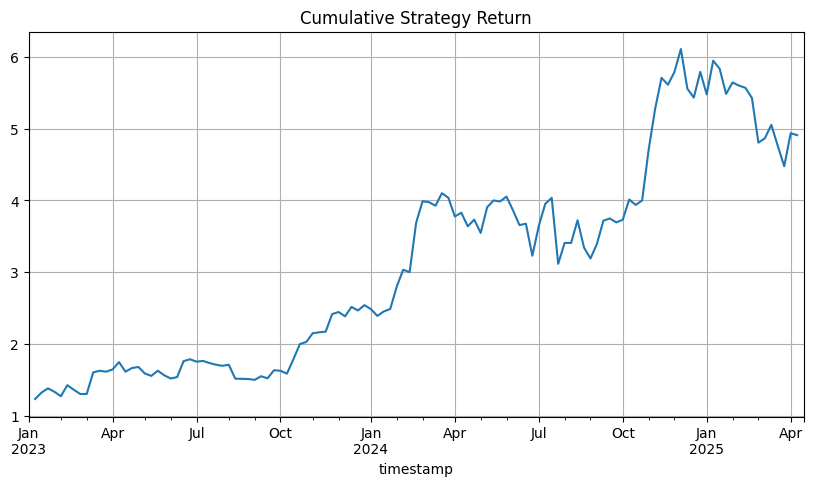

In [30]:
#Predict 

def predict_and_plot(model, X_test, y_test, df):

    y_pred=model.predict(X_test)
    df.loc[X_test.index, 'predicted_signal'] = y_pred

    unique, counts=np.unique(y_pred,return_counts=True)
    [print("predicted Signal Distribution:",dict(zip(unique,counts)))]
    
    df['strategy_return'] = df['predicted_signal'].shift(1) * df['price_change']
    df['cumulative_return'] = (1 + df['strategy_return']).cumprod()
    df['cumulative_return'].plot(title='Cumulative Strategy Return', figsize=(10, 5))
    plt.grid(True)
    plt.show()

predict_and_plot(model, X_test, y_test, btc)



In [32]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

#Predict on test set 
y_pred=model.predict(X_test)

#accuracy score
print("Accuracy:", accuracy_score(y_test,y_pred))

#classification report
print("\nClassification Report:\n",classification_report(y_test,y_pred))

#Confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix,(y_test,y_pred))

Accuracy: 0.44

Classification Report:
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00        13
           0       0.00      0.00      0.00         1
           1       0.44      1.00      0.61        11

    accuracy                           0.44        25
   macro avg       0.15      0.33      0.20        25
weighted avg       0.19      0.44      0.27        25


Confusion Matrix:
 <function confusion_matrix at 0x000001DC211FDF80> (timestamp
2024-11-03 00:00:00+00:00    1
2024-11-10 00:00:00+00:00    1
2024-11-17 00:00:00+00:00    1
2024-11-24 00:00:00+00:00   -1
2024-12-01 00:00:00+00:00    1
2024-12-08 00:00:00+00:00    1
2024-12-15 00:00:00+00:00   -1
2024-12-22 00:00:00+00:00   -1
2024-12-29 00:00:00+00:00    1
2025-01-05 00:00:00+00:00   -1
2025-01-12 00:00:00+00:00    1
2025-01-19 00:00:00+00:00   -1
2025-01-26 00:00:00+00:00   -1
2025-02-02 00:00:00+00:00    1
2025-02-09 00:00:00+00:00   -1
2025-02-16 00:00:00+00:00   -1
20

c:\Users\lnune\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lnune\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lnune\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

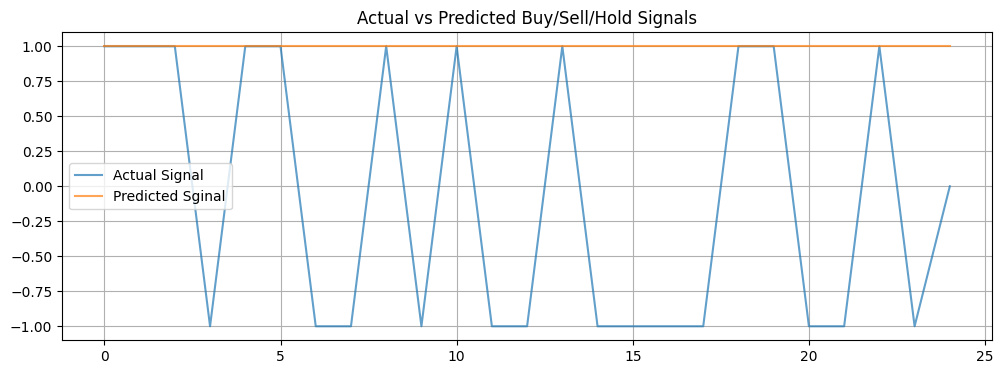

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(y_test.values,label='Actual Signal',alpha=0.7)
plt.plot(y_pred,label='Predicted Sginal',alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted Buy/Sell/Hold Signals')
plt.grid(True)
plt.show()

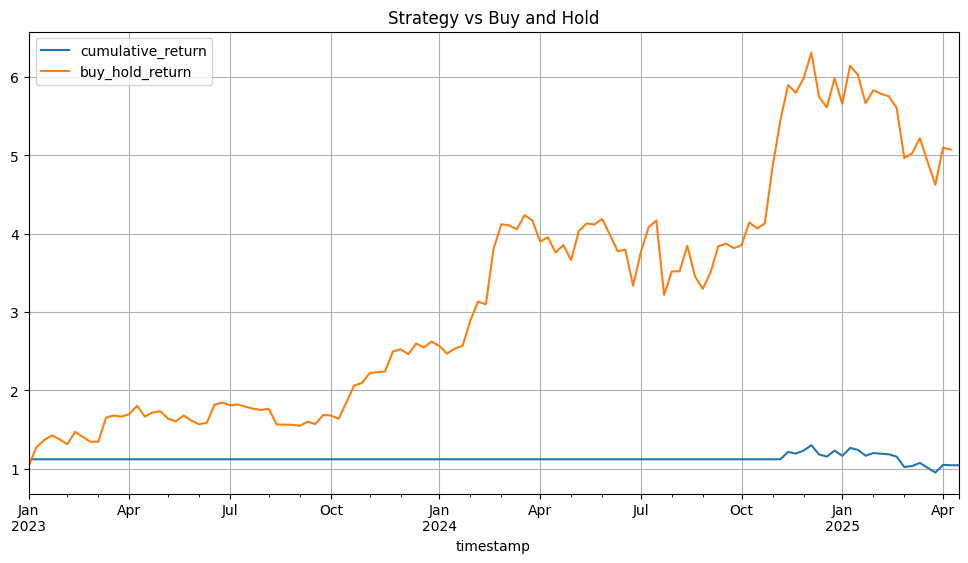

In [27]:
#Strategy return vs Buy-and-Hold Return

#Buy and hold
btc['buy_hold_return']=(1+btc['price_change']).cumprod()

#Strategy vs Buy & Hold
btc[['cumulative_return','buy_hold_return']].plot(figsize=(12,6),title='Strategy vs Buy and Hold')
plt.grid(True)
plt.show()


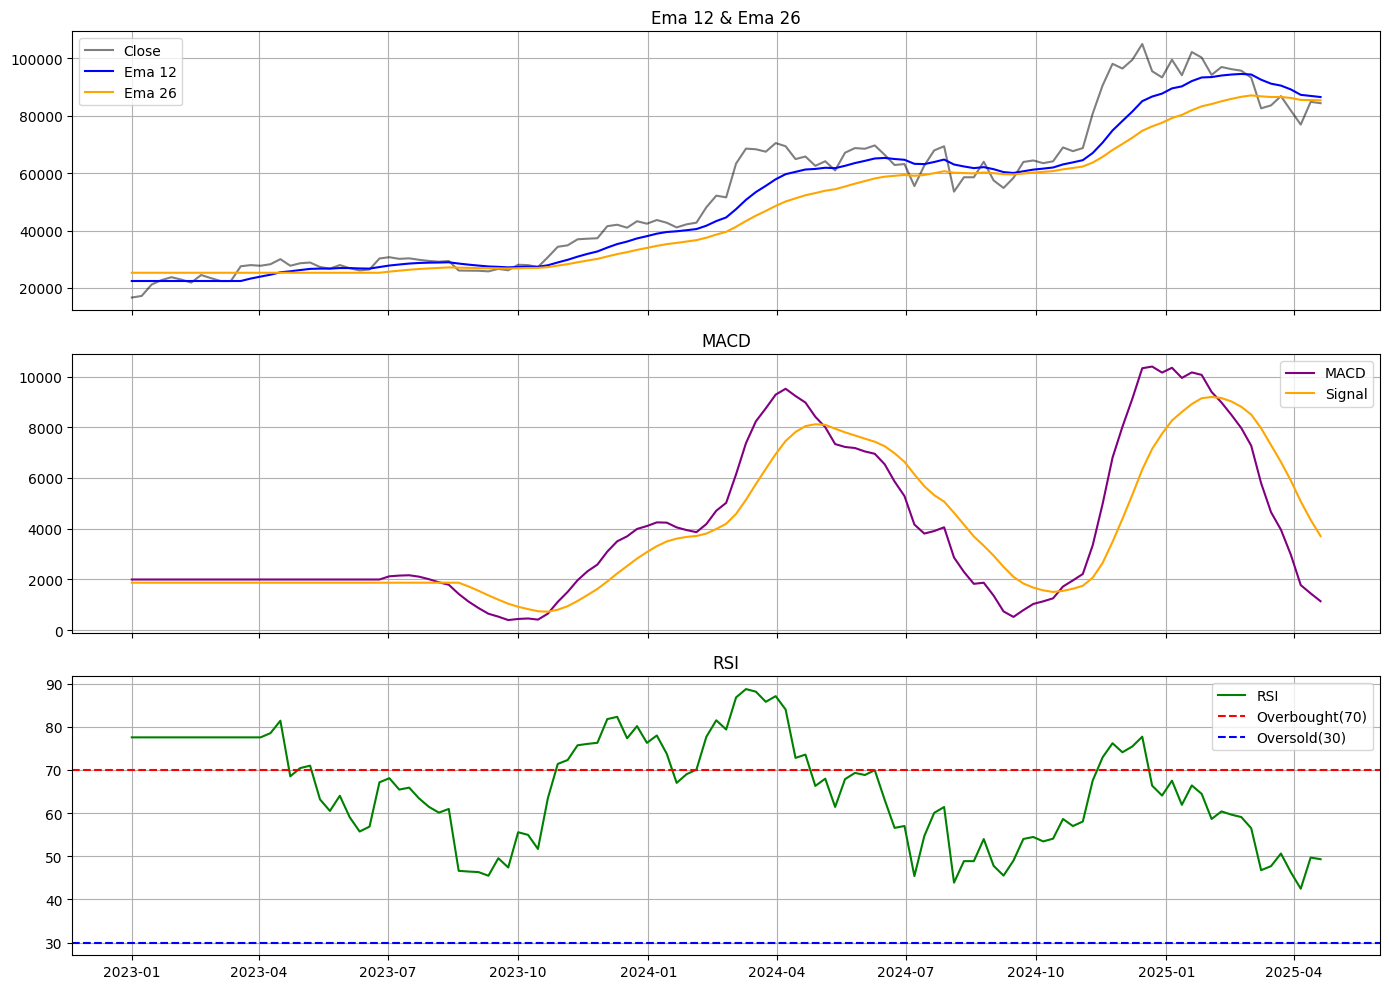

In [28]:
def plot_indicators(df):
    fig,ax=plt.subplots(3,1,figsize=(14,10),sharex=True)

    #plot EMA 12 and EMA 26
    ax[0].plot(df.index, df['close'],label='Close', color='black',alpha=0.5)
    ax[0].plot(df.index, df['ema_12'],label='Ema 12', color= 'blue')
    ax[0].plot(df.index, df['ema_26'],label='Ema 26', color='orange')
    ax[0].set_title('Ema 12 & Ema 26')
    ax[0].legend()
    ax[0].grid(True)

    #plot MACD
    ax[1].plot(df.index, df['macd'],label='MACD', color='purple')
    ax[1].plot(df.index, df['macd_signal'],label='Signal',color='orange')
    ax[1].set_title('MACD')
    ax[1].legend()
    ax[1].grid(True)

    #plot RSI
    ax[2].plot(df.index, df['rsi'],label='RSI', color='green')
    ax[2].axhline(70,color='red',linestyle='--',label='Overbought(70)')
    ax[2].axhline(30,color='blue',linestyle='--',label='Oversold(30)')
    ax[2].set_title('RSI')
    ax[2].legend()
    ax[2].grid(True)

    plt.tight_layout()
    plt.show()


plot_indicators(btc)



    
